In [1]:
import pandas as pd 
import numpy as np
import os      
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time 
from sklearn.metrics import mean_squared_error
path="/home/nakajo/GT_Kids/Results/ML_data/"

In [2]:
df_KID1_ml=pd.read_pickle("df_KID1_ml.pkl")
df_KID3_ml=pd.read_pickle("df_KID3_ml.pkl")
df_KID7_ml=pd.read_pickle("df_KID7_ml.pkl")
df_KID9_ml=pd.read_pickle("df_KID9_ml.pkl")
df_KID11_ml=pd.read_pickle("df_KID11_ml.pkl")

In [ ]:
df_KID11_ml['CPU_temperature(degC)'].plot()

In [ ]:
corr_mat=df_KID11_ml.corr()
sns.set()
sns.heatmap(corr_mat,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.1f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()

In [3]:
import tensorflow as tf
from sklearn import linear_model, preprocessing, cross_validation, svm
from sklearn.svm import SVR

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Restore Model 

In [41]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

def MakeInputData(df_KID, KID_NAME):
    input_current_state=df_KID[['CPU_utilization','FAN (%)', 'CPU_temperature(degC)', 'PS']].reset_index()
    input_job=df_KID[KID_NAME+'_jobs'].reset_index()
    Inp_np=np.empty((0, 5), float)
    for i in range(len(df_KID)-1):
        Inp_series=pd.concat([input_current_state.ix[i], input_job.ix[i+1]]).drop('Elapsed time (s)')
        tmp_np=np.array(Inp_series)
        Inp_np=np.append(Inp_np, [tmp_np], axis=0)
    input_data_np=Inp_np
    return input_data_np

def MakeOutputData(df_KID, KID_NAME):
    output_candidates=df_KID[['CPU_temperature(degC)', KID_NAME+'_serve_time']].reset_index()
    Oup_np=np.empty((0,2), float)
    oup_series=output_candidates.drop('Elapsed time (s)', axis=1)
    tmp_np=np.array(oup_series)
    Oup_np=np.append(Oup_np,tmp_np, axis=0)
    output_data_np=Oup_np[1:] # skip the initital state 
    return output_data_np

def ShowGraph(input_data_np, output_data_np, KID_NAME):
    #予測値(y)の算出
    NN_predict=sess.run(y, feed_dict={x:input_data_np, y_: output_data_np})
    plt.plot(NN_predict[256:, 0], label="NN prediction")
    plt.plot(output_data_np[256:, 0], label="Measured data")
    plt.xlabel("Data point (time_scale)")
    plt.ylabel("Temperature (deg C)")
    plt.title("Model_for_"+ KID_NAME)
    plt.legend()
    print("MSE:", mean_squared_error(output_data_np, NN_predict))

def DetermineNeuron(nInput, nOutput):
    #非線形回帰モデル
    # 30分類器 full=connection
    global W_fc1, b_fc1, h_fc1, W_fc2, b_fc2, h_fc2, keep_prob, W_fc3, b_fc3, y
    #第１層
    W_fc1 = weight_variable([nInput,30])
    b_fc1 = bias_variable([30])
    h_fc1 = tf.nn.relu(tf.matmul(x,W_fc1) + b_fc1) #発火の定義，発火関数はrelu

    #第２層
    W_fc2 = weight_variable([30,10])
    b_fc2 = bias_variable([10])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1,W_fc2) + b_fc2)

    keep_prob = tf.placeholder(tf.float32)  

    #最終層（OutPut）
    W_fc3 = weight_variable([10,nOutput])
    b_fc3 = bias_variable([nOutput])
    y = tf.nn.relu(tf.matmul(h_fc2,W_fc3) + b_fc3)

def DefinePlaceHolder(nInput, nOutput):
    global x, y_, w, b
    x = tf.placeholder(tf.float32, shape=[None, nInput], name = "input")
    #x = tf.placeholder(tf.float32, shape=[nInput], name = "input")
    y_ = tf.placeholder(tf.float32, shape=[None, nOutput], name = "output") 
    #y_ = tf.placeholder(tf.float32, shape=[nOutput], name = "output") 

    w = tf.Variable(tf.zeros([nInput, nOutput]))  #weight
    b = tf.Variable(tf.zeros([nOutput])) #bias
    
def InitiateModel():
    global sess, cross_entropy, train_step
    #y_ = training data , y = predection data 
    cross_entropy = tf.reduce_mean(tf.reduce_sum(tf.square(y - y_)))
    #train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    #sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer()) # Initialize variables
    
def ResetGraph():
    tf.reset_default_graph()  
    
def ShowGraph(input_data_np, output_data_np, KID_NAME, epoch, a, b):
    #予測値(y)の算出
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    #NN_predict=sess.run(y, feed_dict={x:input_data_np, y_: output_data_np})
    NN_predict=sess.run(y, feed_dict={x:input_data_np})
    plt.plot(NN_predict[:, 0], label="NN prediction")
    plt.plot(output_data_np[:, 0], label="Measured data")
    plt.xlabel("Data point (time_scale)")
    plt.ylabel("Temperature (deg C)")
    plt.title("Model_for_"+ KID_NAME)
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.scatter(NN_predict[:, 0], output_data_np[:, 0],  linestyle="solid", marker="o", label="NN_predict")
    plt.xlabel("True values (deg C)") 
    plt.ylabel("Predictions (deg C)")
    plt.title('NN_learning_process')
    plt.legend(loc ="upper right")
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([a,plt.xlim()[1]])
    plt.ylim([a,plt.ylim()[1]])
    _ = plt.plot([a, b], [a, b])
    
    plt.subplot(1, 3, 3)
    error=NN_predict[:, 0]-output_data_np[:, 0]
    plt.hist(error, bins=25)
    plt.xlabel("Prediction error")
    _ = plt.ylabel("Count")
    plt.show()
    print("MSE:", mean_squared_error(output_data_np, NN_predict))
    
    
def Main(df_KID_ml, KID_NAME):
    tf.reset_default_graph()
    path=os.getcwd()
    nInput=5
    nOutput=2
    epoch=10000
    DefinePlaceHolder(nInput, nOutput)
    DetermineNeuron(nInput, nOutput)
    saver = tf.train.Saver()

    with tf.Session() as sess:  # your session object
        InitiateModel()
        saver = tf.train.import_meta_graph(path+'/'+KID_NAME+'_NN_model.ckpt.meta')
        saver.restore(sess, tf.train.latest_checkpoint('./'))
        #sess.run(W_fc1)
        print("Model restored.")
        # Check the values of the variables
        print("W_fc1 : %s" % W_fc1.eval())
        print("W_fc2 : %s" % W_fc2.eval())
        input_data_np_KID=MakeInputData(df_KID_ml, KID_NAME)
        output_data_np_KID=MakeOutputData(df_KID_ml, KID_NAME)
        NN_predict=sess.run(y, feed_dict={x:input_data_np_KID, y_: output_data_np_KID})    
        NN_predict = y.eval(feed_dict={x:input_data_np_KID, y_: output_data_np_KID})
        ShowGraph(input_data_np_KID, output_data_np_KID, KID_NAME, epoch)

In [55]:
os.getcwd()
sns.set()

INFO:tensorflow:Restoring parameters from /home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID1_NN_model/KID1_NN_model.ckpt
Model restored.
W_fc1 : [[-0.05338633  0.05601363  0.19294019 -0.13029745  0.02864335  0.10084976
   0.06065283  0.24685594  0.07840522  0.08370213  0.06178581 -0.04114849
   0.14665791  0.12020395  0.12653954  0.29708418  0.15126912  0.22420119
   0.20198289  0.0482946   0.04284428 -0.05612062  0.1972323   0.08982282
  -0.09922878 -0.10294521 -0.04587743 -0.0567123   0.00428116 -0.08472899]
 [ 0.06342601 -0.0314913   0.08872382  0.0486759   0.05765667  0.08679395
   0.1909666  -0.00565764 -0.04911257 -0.03813022 -0.15881573 -0.00557854
   0.01768482  0.11318641 -0.08300475  0.10751709  0.22760656 -0.03334377
   0.02237377 -0.14748251  0.05878515 -0.12710744  0.0507357   0.08693877
   0.09342489 -0.08739865  0.07937035  0.04297096  0.10444952  0.02011076]
 [-0.17564702 -0.12410756  0.37640116  0.3034235   0.30922785  0.3372901
   0.412114    0.3841021

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


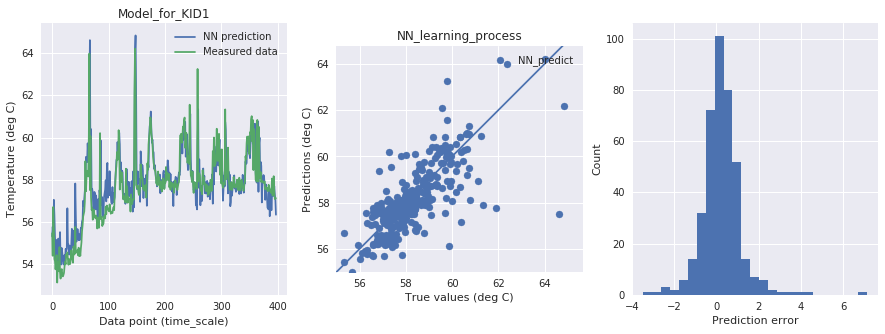

MSE: 0.467059807778275


In [56]:
tf.reset_default_graph()
path=os.getcwd()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

with tf.Session() as sess:  # your session object
    InitiateModel()
    saver = tf.train.import_meta_graph(path+'/KID1_NN_model/KID1_NN_model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(path+'/KID1_NN_model'))
    #sess.run(W_fc1)
    print("Model restored.")
    # Check the values of the variables
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    input_data_np_KID1_test=MakeInputData(df_KID1_ml,"KID1")
    output_data_np_KID1_test=MakeOutputData(df_KID1_ml, "KID1")
    #NN_predict=sess.run(y, feed_dict={x:input_data_np_KID1, y_: output_data_np_KID1})
    NN_predict=sess.run(y, feed_dict={x:input_data_np_KID1_test})  
    #NN_predict=y.eval(feed_dict={x:input_data_np_KID1, y_: output_data_np_KID1})
    ShowGraph(input_data_np_KID1_test, output_data_np_KID1_test, "KID1", epoch, 55, 80)

INFO:tensorflow:Restoring parameters from /home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID3_NN_model/KID3_NN_model.ckpt
Model restored.
W_fc1 : [[-0.03734899 -0.05551687 -0.1427341  -0.1682974   0.14670451 -0.00244946
  -0.1317285  -0.05812975  0.03692747 -0.06125934 -0.06297689  0.10524519
  -0.00447141  0.1431379   0.00843477 -0.15360573  0.13226876 -0.33970612
  -0.06125043  0.20210782  0.00926478  0.09129336  0.02379383  0.09407905
  -0.09281743 -0.06243302  0.16869985 -0.05603169  0.07451077 -0.15435836]
 [ 0.08276831 -0.04351757 -0.09722393 -0.11712749 -0.03607497  0.09251615
  -0.02858716 -0.0984664  -0.03100624  0.08943062  0.05435204  0.01426816
  -0.04240431  0.01273598  0.22614017 -0.17263733  0.09961985 -0.20821707
  -0.1850186  -0.02955448  0.12282092 -0.13535482  0.08976539 -0.1547765
   0.05390884  0.11713272 -0.06781191 -0.08125348  0.15667194 -0.07689917]
 [ 0.23566583  0.19389623 -0.19963469 -0.10683638  0.21847801  0.29844338
  -0.05142188 -0.1705493

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


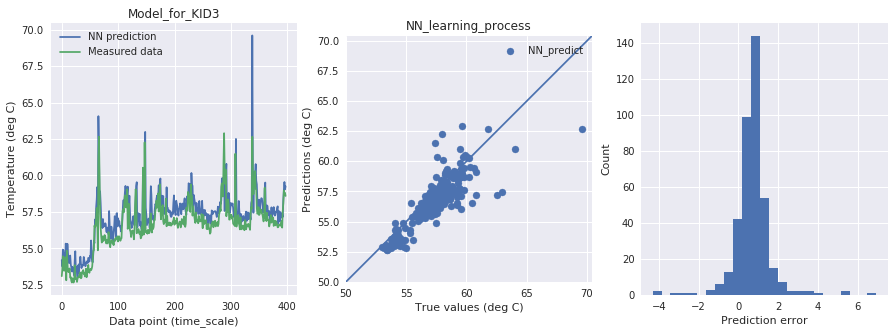

MSE: 0.7212449140077957


In [57]:
tf.reset_default_graph()
path=os.getcwd()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

with tf.Session() as sess:  # your session object
    InitiateModel()
    saver = tf.train.import_meta_graph(path+'/KID3_NN_model/KID3_NN_model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(path+'/KID3_NN_model'))
    #sess.run(W_fc1)
    print("Model restored.")
    # Check the values of the variables
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    input_data_np_KID3_test=MakeInputData(df_KID3_ml,"KID3")
    output_data_np_KID3_test=MakeOutputData(df_KID3_ml, "KID3")
    NN_predict=sess.run(y, feed_dict={x:input_data_np_KID3_test, y_: output_data_np_KID3_test})    
    #NN_predict=sess.run(y, feed_dict={x:input_data_np_KID1})    
    #NN_predict = y.eval(feed_dict={x:input_data_np_KID1, y_: output_data_np_KID1})
    ShowGraph(input_data_np_KID3_test, output_data_np_KID3_test, "KID3", epoch, 50, 80)

INFO:tensorflow:Restoring parameters from /home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID7_NN_model/KID7_NN_model.ckpt
Model restored.
W_fc1 : [[-3.64699587e-02  5.33586293e-02 -1.67778715e-01 -1.32017389e-01
  -7.05290958e-02  1.64055288e-01 -3.43642645e-02 -4.56849150e-02
  -9.20553282e-02 -1.01911716e-01  2.00720116e-01 -1.66361541e-01
   3.84837668e-03 -3.09352297e-02  6.00622892e-02  1.38595849e-01
  -7.88493976e-02 -5.34379371e-02 -5.87613881e-03  7.24940225e-02
   3.76284689e-01  6.35115355e-02 -9.38080810e-03 -7.95939844e-03
  -1.50923938e-01  7.78901428e-02  4.99258786e-02  1.57920599e-01
  -8.08683783e-02  3.83765809e-02]
 [ 2.19469685e-02 -1.60162672e-02  9.18337032e-02 -1.16681211e-01
   6.72380850e-02  5.16544133e-02 -5.00627272e-02  1.36842206e-01
   4.92281877e-02 -3.51629853e-02  1.03006616e-01  1.73035353e-01
   5.66584133e-02  2.68439222e-02  2.50776082e-01  2.08789065e-01
  -1.28188029e-01  4.40397151e-02  8.46280828e-02  1.59446616e-02
  -1.9384515

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


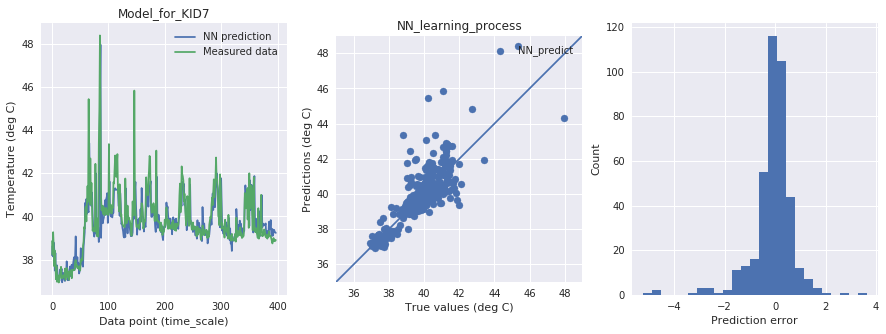

MSE: 0.3633916150013286


In [58]:
tf.reset_default_graph()
path=os.getcwd()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

with tf.Session() as sess:  # your session object
    InitiateModel()
    saver = tf.train.import_meta_graph(path+'/KID7_NN_model/KID7_NN_model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(path+'/KID7_NN_model'))
    #sess.run(W_fc1)
    print("Model restored.")
    # Check the values of the variables
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    input_data_np_KID7_test=MakeInputData(df_KID7_ml,"KID7")
    output_data_np_KID7_test=MakeOutputData(df_KID7_ml, "KID7")
    #NN_predict=sess.run(y, feed_dict={x:input_data_np_KID7_test, y_: output_data_np_KID7_test})
    NN_predict=sess.run(y, feed_dict={x:input_data_np_KID7_test})    
    #NN_predict = y.eval(feed_dict={x:input_data_np_KID7_test, y_: output_data_np_KID7_test})
    ShowGraph(input_data_np_KID7_test, output_data_np_KID7_test, "KID7", epoch, 35, 50)

INFO:tensorflow:Restoring parameters from /home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID9_NN_model/KID9_NN_model.ckpt
Model restored.
W_fc1 : [[-0.05561017 -0.04518554  0.12193824  0.1410859   0.02363318  0.10101599
   0.06604687  0.14812863  0.22244592  0.12097082  0.14515086  0.23064558
   0.12325975 -0.07681815  0.12157869  0.0503413   0.07844321  0.05499284
   0.0717757  -0.022286   -0.45480114  0.05970235  0.05181633 -0.07848155
   0.163364    0.07784706 -0.03102196  0.03701268 -0.0944977  -0.01873326]
 [ 0.13403209 -0.03497912 -0.00560454  0.13372357 -0.18398581  0.36204556
   0.11686005  0.1293542   0.01181361  0.18042803  0.2045152   0.05622489
   0.2590672  -0.18977007  0.24419275 -0.11259162  0.15014796 -0.11615669
   0.14446993  0.03291056  0.24902673  0.21584967 -0.01847396  0.11394415
  -0.00333834  0.19168636  0.1756728   0.06319157 -0.09124421  0.04490492]
 [ 0.31863558 -0.01059083  0.22462173 -0.07029717 -0.11650508  0.44633967
   0.2887674   0.408545

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


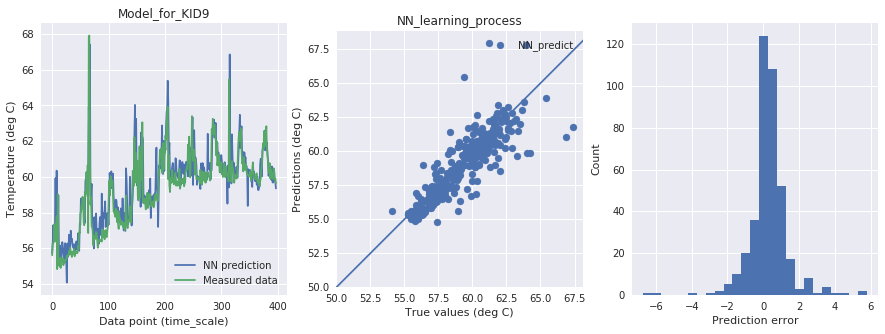

MSE: 0.6730982468717934


In [59]:
tf.reset_default_graph()
path=os.getcwd()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

with tf.Session() as sess:  # your session object
    InitiateModel()
    saver = tf.train.import_meta_graph(path+'/KID9_NN_model/KID9_NN_model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(path+'/KID9_NN_model'))
    #sess.run(W_fc1)
    print("Model restored.")
    # Check the values of the variables
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    input_data_np_KID1=MakeInputData(df_KID9_ml,"KID9")
    output_data_np_KID1=MakeOutputData(df_KID9_ml, "KID9")
    NN_predict=sess.run(y, feed_dict={x:input_data_np_KID1, y_: output_data_np_KID1})    
    NN_predict = y.eval(feed_dict={x:input_data_np_KID1, y_: output_data_np_KID1})
    ShowGraph(input_data_np_KID1, output_data_np_KID1, "KID9", epoch, 50, 80)

INFO:tensorflow:Restoring parameters from /home/nakajo/GT_Kids/Results/ML_data/vailidation_ver1/ml_data/KID11_NN_model/KID11_NN_model.ckpt
Model restored.
W_fc1 : [[ 0.01469887 -0.10208206  0.17312767 -0.00218387  0.14485587 -0.09828532
   0.10640035 -0.00164698  0.15051065  0.13387388  0.03774777  0.1315142
   0.01586782 -0.03454926  0.00848748  0.22704795  0.13555692  0.15547197
   0.121503    0.15535335  0.00617108  0.06446939  0.20442295 -0.01882352
   0.1156004   0.00880275  0.14181653  0.08128577  0.15216596  0.0606036 ]
 [-0.05220462  0.10665935  0.04896806 -0.02497041  0.00327692  0.00934326
   0.0034608  -0.01399359 -0.08333348 -0.05682821  0.22988765 -0.06596684
  -0.01187866 -0.11284394 -0.08814526  0.10301402 -0.06893118  0.0281218
  -0.05191826  0.13376428  0.01611172 -0.09582148  0.04160673  0.04086252
   0.03228799 -0.0173979   0.11688254 -0.04138528  0.17708394  0.12642671]
 [ 0.29507315 -0.09002873 -0.06815562 -0.12795635  0.27898797  0.26078194
   0.32491282 -0.090174

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


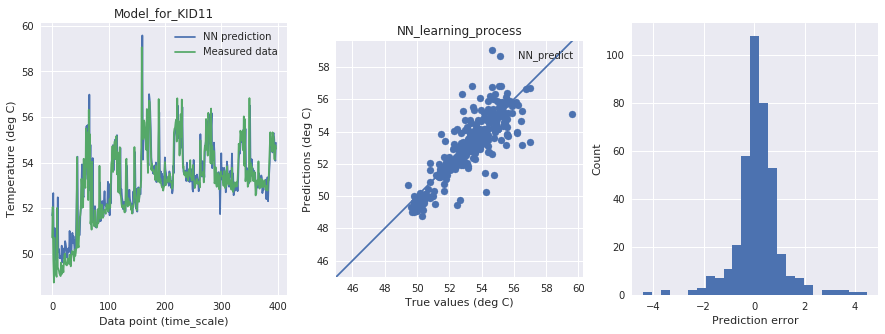

MSE: 0.435413724623395


In [105]:
tf.reset_default_graph()
path=os.getcwd()
nInput=5
nOutput=2
epoch=10000
DefinePlaceHolder(nInput, nOutput)
DetermineNeuron(nInput, nOutput)
saver = tf.train.Saver()

with tf.Session() as sess:  # your session object
    InitiateModel()
    saver = tf.train.import_meta_graph(path+'/KID11_NN_model/KID11_NN_model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(path+'/KID11_NN_model'))
    #saver.restore(sess, path+'/KID11_NN_model')
    #sess.run(W_fc1)
    print("Model restored.")
    # Check the values of the variables
    print("W_fc1 : %s" % W_fc1.eval())
    #print("W_fc2 : %s" % W_fc2.eval())
    input_data_np_KID1=MakeInputData(df_KID11_ml,"KID11")
    output_data_np_KID1=MakeOutputData(df_KID11_ml, "KID11")
    NN_predict=sess.run(y, feed_dict={x:input_data_np_KID1, y_: output_data_np_KID1})    
    NN_predict = y.eval(feed_dict={x:input_data_np_KID1, y_: output_data_np_KID1})
    ShowGraph(input_data_np_KID1, output_data_np_KID1, "KID11", epoch, 45, 80)

In [104]:
input_data_np_KID1=MakeInputData(df_KID1_ml,"KID1")
input_data_np_KID1[0:2,:]

/home/nakajo/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


array([[2.00000000e-02, 2.78300000e+01, 5.46458333e+01, 3.00000000e+00,
        2.00000000e+01],
       [9.33333333e-02, 2.78300000e+01, 5.54583333e+01, 2.35714286e+00,
        1.50000000e+01]])

In [89]:
input_data_np_KID1

array([[2.00000000e-02, 2.78300000e+01, 5.46458333e+01, 3.00000000e+00,
        2.00000000e+01],
       [9.33333333e-02, 2.78300000e+01, 5.54583333e+01, 2.35714286e+00,
        1.50000000e+01],
       [1.00000000e-01, 2.78300000e+01, 5.43958333e+01, 3.56666667e+00,
        2.50000000e+01],
       ...,
       [6.30000000e-01, 2.78300000e+01, 5.74166667e+01, 5.63888889e+00,
        1.50000000e+01],
       [5.80000000e-01, 2.78300000e+01, 5.70833333e+01, 4.89166667e+00,
        1.50000000e+01],
       [5.80000000e-01, 2.78300000e+01, 5.71041667e+01, 5.21666667e+00,
        1.00000000e+01]])

In [99]:
input_data_np_KID1.shape

(398, 5)